## Building a Deep Iris Detection Model

### 1. Install Dependencies and Setup

In [1]:
# !pip install tensorflow tensorflow-gpu opencv-python matplotlib 

In [2]:
import os
import cv2
import tensorflow as tf
import json
import numpy as np
import matplotlib.pyplot as plt

2025-08-02 12:14:47.442712: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
# gpus = tf.config.experimental.list_physical_devices('GPU')
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)

### 2. Load Data

#### 2.1 Load Images

In [4]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [5]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (250, 250)))
train_images = train_images.map(lambda x: x/255)

2025-08-02 13:34:18.490297: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
train_images.as_numpy_iterator().next()

array([[[0.48062745, 0.32768625, 0.09631372],
        [0.4647843 , 0.32360783, 0.08831372],
        [0.47843137, 0.3372549 , 0.10196079],
        ...,
        [0.9945098 , 0.9984314 , 0.97882354],
        [0.99435306, 0.9962353 , 0.9786668 ],
        [0.99607843, 0.99215686, 0.9843137 ]],

       [[0.4905098 , 0.33756864, 0.10619608],
        [0.48596078, 0.3330196 , 0.10164706],
        [0.49490196, 0.34588233, 0.1027451 ],
        ...,
        [0.99294114, 0.9968627 , 0.97725487],
        [0.99545103, 0.99545103, 0.9876079 ],
        [0.99607843, 0.99215686, 0.9843137 ]],

       [[0.5011765 , 0.34039217, 0.12078431],
        [0.50039214, 0.3435294 , 0.11215686],
        [0.49411765, 0.3372549 , 0.09803922],
        ...,
        [0.99215686, 1.        , 0.98039216],
        [0.989804  , 0.989804  , 0.9819609 ],
        [0.99215686, 0.99215686, 0.99215686]],

       ...,

       [[0.4690196 , 0.50039214, 0.4572549 ],
        [0.45960784, 0.49882352, 0.45568627],
        [0.46666667, 0

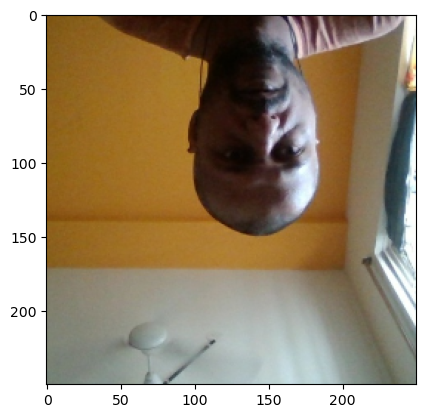

In [9]:
plt.imshow(train_images.as_numpy_iterator().next())

In [10]:
train_images.as_numpy_iterator().next().shape

(250, 250, 3)

In [11]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (250, 250)))
test_images = test_images.map(lambda x: x/255)

In [12]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (250, 250)))
val_images = val_images.map(lambda x: x/255)

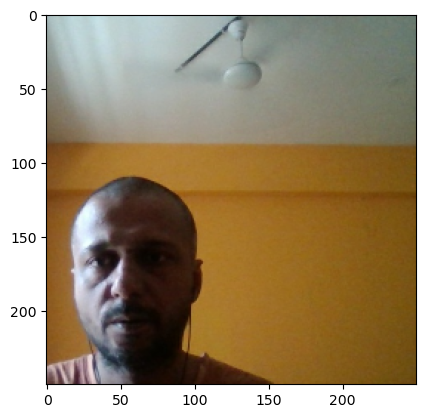

In [14]:
plt.imshow(val_images.as_numpy_iterator().next())

#### 2.2 Prepare Labels

In [15]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding='utf-8') as f:
        label = json.load(f)
    return [label['keypoints']]

In [16]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [17]:
train_labels.as_numpy_iterator().next()

2025-08-02 13:51:49.364038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [840]
	 [[{{node Placeholder/_0}}]]


(array([0.5107, 0.3833, 0.6577, 0.3687], dtype=float16),)

In [18]:
# First two values : X - Left Eye, Y - Left Eye
# Second two values: X - Right Eye, Y - Right Eye

In [19]:
test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [20]:
val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.float16]))

In [21]:
val_labels.as_numpy_iterator().next()

2025-08-02 13:56:49.576457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [180]
	 [[{{node Placeholder/_0}}]]


(array([0.2905, 0.6577, 0.1451, 0.6675], dtype=float16),)

#### 2.3 Combine Labels and Images

In [22]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(840)
train = train.batch(16)
train = train.prefetch(4)

In [25]:
train.as_numpy_iterator().next()

(array([[[[0.49615684, 0.5471372 , 0.5196862 ],
          [0.4787451 , 0.5297255 , 0.5022745 ],
          [0.48941177, 0.54039216, 0.5129412 ],
          ...,
          [0.4690196 , 0.53176475, 0.492549  ],
          [0.48549014, 0.54823524, 0.50901955],
          [0.47607854, 0.5388236 , 0.49568638]],
 
         [[0.49866667, 0.55749017, 0.5300392 ],
          [0.49709806, 0.5560784 , 0.5281568 ],
          [0.48313725, 0.53411764, 0.49882352],
          ...,
          [0.46745098, 0.5301961 , 0.4909804 ],
          [0.47764707, 0.5443137 , 0.50509804],
          [0.47058833, 0.5333335 , 0.49411774]],
 
         [[0.4862745 , 0.54509807, 0.5176471 ],
          [0.4862745 , 0.54901963, 0.50980395],
          [0.49411765, 0.5568628 , 0.5176471 ],
          ...,
          [0.4745098 , 0.5372549 , 0.49803922],
          [0.46431383, 0.53098047, 0.4917648 ],
          [0.4564707 , 0.52313733, 0.4917648 ]],
 
         ...,
 
         [[0.99607843, 1.        , 0.98039216],
          [0.99607

In [26]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(180)
test = test.batch(16)
test = test.prefetch(4)

In [27]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(180)
val = val.batch(16)
val = val.prefetch(4)

#### 2.4 View Samples

In [28]:
data_samples = train.as_numpy_iterator()

In [29]:
res = data_samples.next()

In [31]:
len(res)

2

In [32]:
res[0]

array([[[[8.6478430e-01, 9.1184312e-01, 9.0713722e-01],
         [7.1058822e-01, 7.6549017e-01, 7.7098036e-01],
         [7.3647058e-01, 7.8745097e-01, 8.1882352e-01],
         ...,
         [5.0509804e-01, 5.2862746e-01, 5.1294118e-01],
         [5.0745094e-01, 5.3662735e-01, 5.1905876e-01],
         [4.9568638e-01, 5.3725493e-01, 5.0588238e-01]],

        [[9.5356858e-01, 9.8870587e-01, 9.8823529e-01],
         [7.7819610e-01, 8.3121574e-01, 8.3733332e-01],
         [7.1607846e-01, 7.6705885e-01, 7.9686272e-01],
         ...,
         [5.2627450e-01, 5.4588234e-01, 5.3019607e-01],
         [5.1529419e-01, 5.3803927e-01, 5.2235299e-01],
         [5.0070602e-01, 5.3505892e-01, 5.1576477e-01]],

        [[9.6784317e-01, 1.0000000e+00, 9.9294114e-01],
         [9.2784315e-01, 9.6784317e-01, 9.7098041e-01],
         [7.0588237e-01, 7.5686276e-01, 7.8039217e-01],
         ...,
         [5.3333336e-01, 5.5294120e-01, 5.2941179e-01],
         [5.1450986e-01, 5.4196084e-01, 5.1450986e-01],
  

In [34]:
res[0].shape

(16, 250, 250, 3)

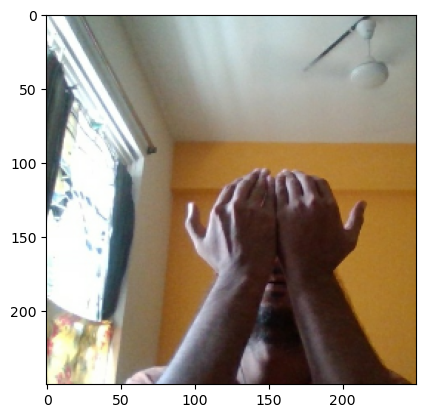

In [37]:
plt.imshow(res[0][0])

In [40]:
 res[1][0][0]

array([0., 0., 0., 0.], dtype=float16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


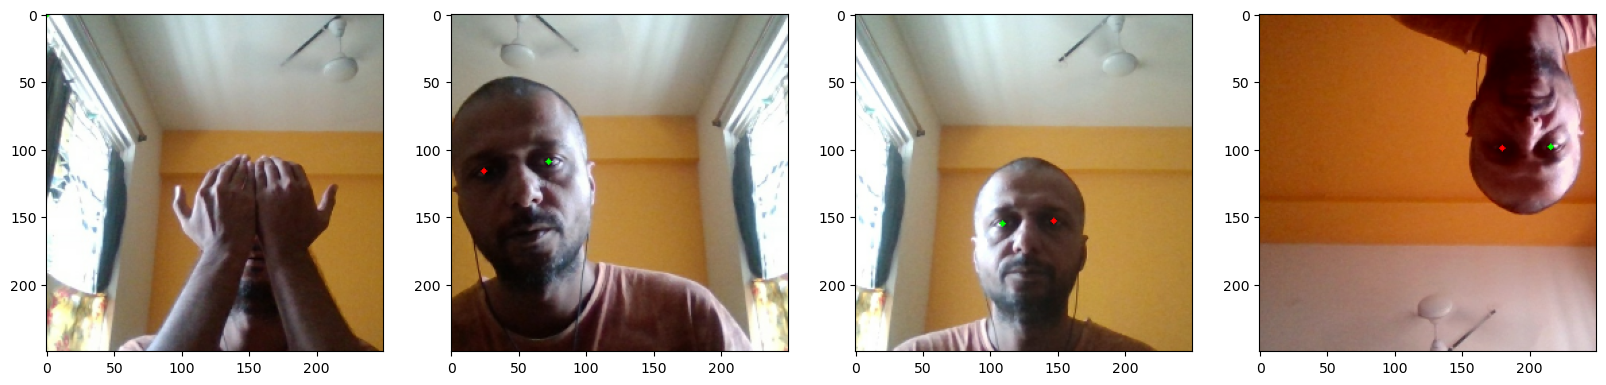

In [42]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][0][idx]

    # Red Circle - Left
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250, 250]).astype(int)), 2, (255, 0, 0), -1)
    # Green Circle - Right
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250, 250]).astype(int)), 2, (0, 255, 0), -1)

    ax[idx].imshow(sample_image)

### 3. Build Model

#### 3.1 Create Neural Network

In [70]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import ResNet152V2

In [71]:
# Load the base model and freeze it 
resnet_base = ResNet152V2(include_top=False, input_shape=(250, 250, 3))
resnet_base.trainable = False  # freezing the model

model = Sequential([
    Input(shape=(250, 250, 3)),
    resnet_base,
    Conv2D(128, 3, padding='same', activation='relu'),
    Conv2D(64, 2, 2, activation='relu'),
    Dropout(0.05),
    Conv2D(4, 2, 2),
    GlobalAveragePooling2D()
])

In [72]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, 8, 8, 2048)        58331648  
                                                                 
 conv2d_36 (Conv2D)          (None, 8, 8, 128)         2359424   
                                                                 
 conv2d_37 (Conv2D)          (None, 4, 4, 64)          32832     
                                                                 
 dropout_9 (Dropout)         (None, 4, 4, 64)          0         
                                                                 
 conv2d_38 (Conv2D)          (None, 2, 2, 4)           1028      
                                                                 
 global_average_pooling2d (G  (None, 4)                0         
 lobalAveragePooling2D)                                          
                                                      

#### 3.2 Setup Losses and Optimizer

In [73]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.005, decay=0.0007)
loss = tf.keras.losses.MeanSquaredError()

In [74]:
model.compile(optimizer, loss)

#### 3.3 Sense Check Predictions

In [75]:
X, y = train.as_numpy_iterator().next()

In [76]:
X.shape

(16, 250, 250, 3)

In [77]:
coordinates = model.predict(X)

1/1 [==============================] - 21s 21s/step


In [78]:
coordinates

array([[-0.17492615,  0.62329304,  0.93975776,  1.0275109 ],
       [-0.8716666 ,  1.577656  ,  0.83155006,  1.3229043 ],
       [-0.76205516,  2.897418  ,  0.7938602 ,  0.9681104 ],
       [-0.94572335,  2.097669  ,  0.92723954,  1.419671  ],
       [-1.2925928 ,  3.2876706 ,  0.36683202,  1.182209  ],
       [-0.72047865,  1.1071025 , -0.56458217,  0.28689528],
       [-1.4498478 ,  3.4162996 ,  1.0001382 ,  1.1168768 ],
       [-0.6545352 ,  2.984282  , -0.8443811 ,  1.491372  ],
       [-1.1023743 ,  1.2114217 , -0.26197457,  1.6331692 ],
       [-1.1175988 ,  2.0537634 ,  0.10223699,  0.5711971 ],
       [-0.11525408,  2.1705365 , -0.37417608,  0.6719889 ],
       [-0.5747415 ,  1.5428346 ,  1.0149169 ,  0.9613561 ],
       [-0.8959223 ,  1.3298347 , -0.4327996 ,  0.83138114],
       [ 0.0677346 ,  2.6247888 , -0.84800404,  0.8901856 ],
       [-0.5493155 ,  0.9797054 , -0.14960752,  0.7015688 ],
       [-2.6224146 ,  2.261257  ,  1.1399437 ,  1.1628114 ]],
      dtype=float32)

#### 3.4 Train the Model

In [79]:
hist = model.fit(train, epochs=1, validation_data=val)

53/53 [==============================] - ETA: 0s - loss: 78.8736     

2025-08-02 15:35:14.018367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [180]
	 [[{{node Placeholder/_0}}]]
2025-08-02 15:35:14.018757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [180]
	 [[{{node Placeholder/_0}}]]


53/53 [==============================] - 1193s 22s/step - loss: 78.8736 - val_loss: 0.0793


### 4. Review Performance

#### 4.1 View Loss Plots

In [80]:
hist.history

{'loss': [78.87358856201172], 'val_loss': [0.07929683476686478]}

#### 4.2 Make Predictions on Test

In [88]:
test_data = test.as_numpy_iterator()

In [89]:
test_sample = test_data.next()

In [90]:
yhat = model.predict(test_sample[0])

1/1 [==============================] - 19s 19s/step


In [91]:
yhat

array([[ 7.48279929e-01,  5.18377960e-01,  7.81715572e-01,
         8.56914878e-01],
       [ 2.07202584e-01,  9.27866846e-02,  1.21001385e-01,
        -1.45763531e-03],
       [ 7.13608637e-02,  4.63871241e-01, -1.49214417e-02,
        -5.02061434e-02],
       [ 4.48919117e-01,  4.68644410e-01,  5.69826007e-01,
         6.01059258e-01],
       [ 8.90090466e-02,  1.43075287e-01,  4.12220597e-01,
         2.00207889e-01],
       [ 4.66832101e-01,  7.02614486e-01,  7.64536202e-01,
         4.56599444e-01],
       [ 4.13911730e-01,  2.93870926e-01, -2.26520091e-01,
         9.19528455e-02],
       [ 5.65801978e-01, -7.71775842e-04,  4.56979215e-01,
         6.54036403e-01],
       [ 5.32685876e-01,  6.13841832e-01,  6.56281039e-02,
         3.80862504e-01],
       [ 5.03301680e-01,  4.42635506e-01,  7.58718133e-01,
         8.12498689e-01],
       [ 3.95290583e-01,  3.95398796e-01,  6.37558579e-01,
         5.54884613e-01],
       [ 4.79856163e-01,  8.42360407e-02,  5.31948447e-01,
      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


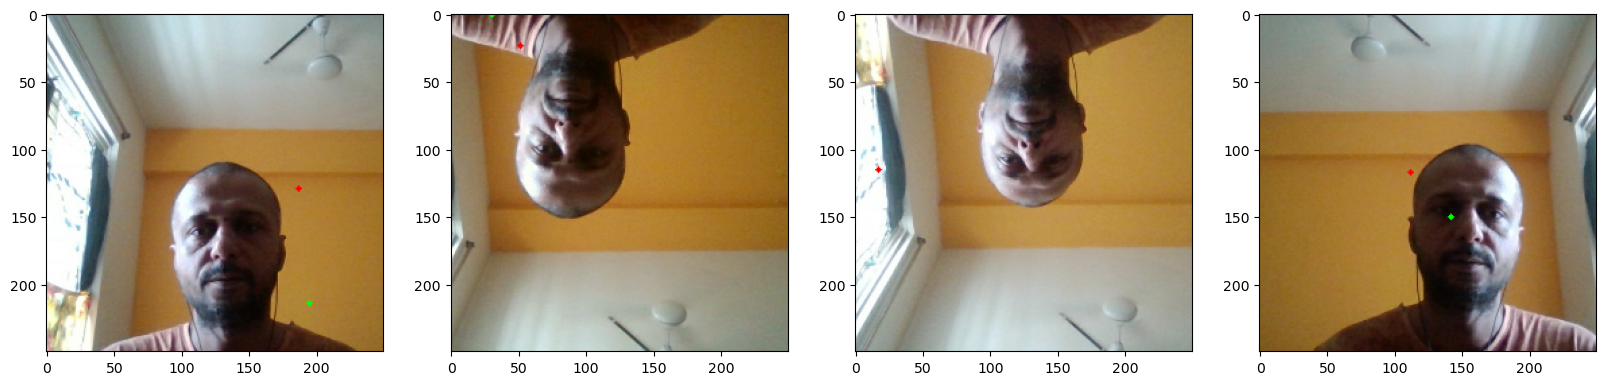

In [92]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = yhat[idx]

    # Red Circle - Left
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250, 250]).astype(int)), 2, (255, 0, 0), -1)
    # Green Circle - Right
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250, 250]).astype(int)), 2, (0, 255, 0), -1)

    ax[idx].imshow(sample_image)

#### 4.3 Save the Model

In [93]:
from tensorflow.keras.models import load_model

In [94]:
model.save('eyetracker1epoch.h5')

In [95]:
model = load_model('eyetracker1epoch.h5')

In [96]:
model.predict(test_sample[0])

1/1 [==============================] - 21s 21s/step


array([[-2.0876038e+00,  6.1920156e+00, -3.4339185e+00, -7.9287887e-01],
       [ 8.1490058e-01,  9.6869373e-01,  3.5739274e+00,  3.7335427e+00],
       [-7.1431704e+00,  5.1920104e+00, -4.4809413e-01,  2.7528775e+00],
       [ 2.2577100e+00, -2.0325890e+00,  4.1833973e+00,  5.3928404e+00],
       [ 8.9009047e-02,  1.4307529e-01,  4.1222060e-01,  2.0020789e-01],
       [ 4.6683210e-01,  7.0261449e-01,  7.6453620e-01,  4.5659944e-01],
       [ 4.1391173e-01,  2.9387093e-01, -2.2652009e-01,  9.1952845e-02],
       [ 5.6580198e-01, -7.7177584e-04,  4.5697922e-01,  6.5403640e-01],
       [ 5.3268588e-01,  6.1384183e-01,  6.5628104e-02,  3.8086250e-01],
       [ 5.0330168e-01,  4.4263551e-01,  7.5871813e-01,  8.1249869e-01],
       [ 3.9529058e-01,  3.9539880e-01,  6.3755858e-01,  5.5488461e-01],
       [ 4.7985616e-01,  8.4236041e-02,  5.3194845e-01,  5.9474993e-01],
       [ 2.8944519e-01,  3.0782992e-01,  3.3176222e-01,  4.8901856e-01],
       [ 2.4705487e-01,  3.7334242e-01,  3.1071848e

### 5. Real Time Detection

In [97]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()

    frame = frame[50:500, 50:500, :]
    rgb_img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(rgb_img, (250,250))

    yhat = model.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[0, :4]

    cv2.circle(sample_image, tuple(np.multiply(sample_coords[:2], [250, 250]).astype(int)), 2, (255, 0, 0), -1)
    cv2.circle(sample_image, tuple(np.multiply(sample_coords[2:], [250, 250]).astype(int)), 2, (0, 255, 0), -1)

    cv2.imshow('EyeTrack', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

[ WARN:0@13559.029] global /croot/opencv-suite_1691620365762/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


1/1 [==============================] - 2s 2s/step


qt.glx: qglx_findConfig: Failed to finding matching FBConfig for QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
No XVisualInfo for format QSurfaceFormat(version 2.0, options QFlags<QSurfaceFormat::FormatOption>(), depthBufferSize -1, redBufferSize 1, greenBufferSize 1, blueBufferSize 1, alphaBufferSize -1, stencilBufferSize -1, samples -1, swapBehavior QSurfaceFormat::SingleBuffer, swapInterval 1, colorSpace QSurfaceFormat::DefaultColorSpace, profile  QSurfaceFormat::NoProfile)
Falling back to using screens root_visual.


1/1 [==============================] - 1s 1s/step
